In [1]:
import os
 
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "malaria/cell_images"
 
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "malaria"
 
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
 
# define the amount of data that will be used training
TRAIN_SPLIT = 0.8
 
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1

In [2]:
from pyimagesearch import config
from imutils import paths
import random
import shutil
import os
 
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [3]:
# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]
 
# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

In [4]:
datasets = [
	("training", trainPaths, config.TRAIN_PATH),
	("validation", valPaths, config.VAL_PATH),
	("testing", testPaths, config.TEST_PATH)
]

In [5]:
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split


In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights = "imagenet",
include_top = False, input_shape =(64,64,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1 / 255.0)

In [8]:
datagen = ImageDataGenerator(rescale=1./255,
                            shear_range = 0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
batch_size = 4


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        class_mode="binary",
        target_size=(64, 64),
        batch_size=batch_size,
        color_mode="rgb")
    
    i = 0
    for inputs_batch, labels_batch in generator:


        #print(labels_batch)
        features_batch = conv_base.predict(inputs_batch)
        #print(features_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        #print(i)
        if ((i * batch_size % 1000) == 0 ):
            print("processed size =", i * batch_size)
        if i * batch_size >= sample_count:
            break

    return features, labels  

In [9]:
# Extract validation features
nVal = 2204
val_features, val_labels = extract_features(config.VAL_PATH, nVal)

Found 2204 images belonging to 2 classes.
processed size = 1000
processed size = 2000


In [10]:
np.save('validation_features', val_features)
np.save('validation_labels', val_labels)

In [11]:
# Extract test features
nTest = 5512
test_features, test_labels = extract_features(config.TEST_PATH, nTest)

Found 5512 images belonging to 2 classes.
processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000


In [12]:
np.save('test_features', test_features)
np.save('test_labels', test_labels)

In [13]:
# Extract train features
nTrain = 19842
train_features, train_labels = extract_features(config.TRAIN_PATH, nTrain)

Found 19842 images belonging to 2 classes.
processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000
processed size = 6000
processed size = 7000
processed size = 8000
processed size = 9000
processed size = 10000
processed size = 11000
processed size = 12000
processed size = 13000
processed size = 14000
processed size = 15000
processed size = 16000
processed size = 17000
processed size = 18000
processed size = 19000


In [14]:
np.save('train_features', train_features)
np.save('train_labels', train_labels)

# Load the features

In [15]:
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')
validation_features = np.load('validation_features.npy')

In [16]:
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')
validation_labels = np.load('validation_labels.npy')

In [17]:
nVal = 2204
nTrain = 19842
nTest = 5512

In [49]:
train_features = np.reshape(train_features, (nTrain, 2 * 2 * 512))
test_features = np.reshape(test_features, (nTest, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (nVal, 2 * 2 * 512))

In [19]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
 
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
 
# loop over the input image paths
    for inputPath in imagePaths:
        # extract the filename of the input image along with its
        # corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]
 
        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])
 
        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
 
        # construct the path to the destination image and then copy
        # the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split


In [20]:
from keras import models
from keras import layers
from keras import optimizers
model1 = models.Sequential()
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.7))
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model1.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
4961/4961 [==============================] - 28s 5ms/step - loss: 0.4825 - acc: 0.7719 - val_loss: 0.3079 - val_acc: 0.8848
Epoch 2/30
4961/4961 [==============================] - 26s 5ms/step - loss: 0.3378 - acc: 0.8651 - val_loss: 0.2806 - val_acc: 0.9056
Epoch 3/30
4961/4961 [==============================] - 26s 5ms/step - loss: 0.3225 - acc: 0.8823 - val_loss: 0.3040 - val_acc: 0.8925
Epoch 4/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.3030 - acc: 0.8863 - val_loss: 0.2561 - val_acc: 0.9025
Epoch 5/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.2938 - acc: 0.8908 - val_loss: 0.2811 - val_acc: 0.8952
Epoch 6/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.2948 - acc: 0.8951 - val_loss: 0.2622 - val_acc: 0.9034
Epoch 7/30
4961/4961 [==============================] - 24s 5ms/step - loss: 0.2956 - acc: 0.8934 - val_loss: 0.2728 - val_acc: 0.9093
Epoch 8/30
4961/4961 [==============================] -

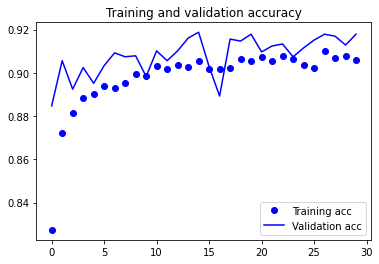

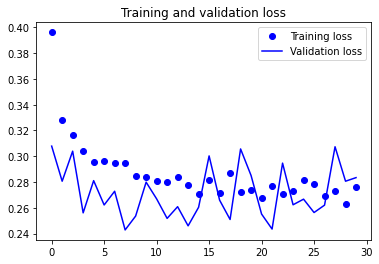

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
model1.evaluate(test_features,test_labels)

173/173 [==============================] - 1s 3ms/step - loss: 0.2708 - acc: 0.9247


[0.27082502841949463, 0.9247097373008728]

In [32]:
from keras import models
from keras import layers
from keras import optimizers
model2 = models.Sequential()
model2.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.3876 - acc: 0.8213 - val_loss: 0.2490 - val_acc: 0.9029
Epoch 2/30
4961/4961 [==============================] - 24s 5ms/step - loss: 0.2762 - acc: 0.8919 - val_loss: 0.2446 - val_acc: 0.9079
Epoch 3/30
4961/4961 [==============================] - 28s 6ms/step - loss: 0.2538 - acc: 0.9061 - val_loss: 0.2505 - val_acc: 0.9043
Epoch 4/30
4961/4961 [==============================] - 29s 6ms/step - loss: 0.2562 - acc: 0.9071 - val_loss: 0.2304 - val_acc: 0.9115
Epoch 5/30
4961/4961 [==============================] - 24s 5ms/step - loss: 0.2439 - acc: 0.9127 - val_loss: 0.2325 - val_acc: 0.9111
Epoch 6/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.2403 - acc: 0.9116 - val_loss: 0.2368 - val_acc: 0.9074
Epoch 7/30
4961/4961 [==============================] - 25s 5ms/step - loss: 0.2269 - acc: 0.9175 - val_loss: 0.2272 - val_acc: 0.9142
Epoch 8/30
4961/4961 [==============================] -

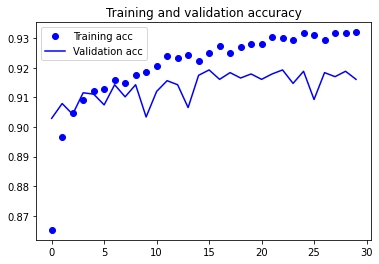

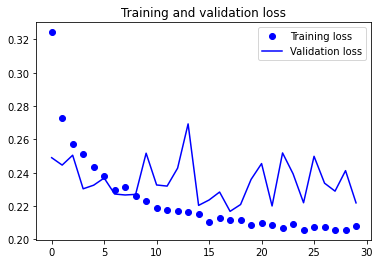

In [35]:
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
model2.evaluate(test_features,test_labels)

173/173 [==============================] - 1s 4ms/step - loss: 0.2087 - acc: 0.9282


[0.20874659717082977, 0.9281567335128784]

In [53]:
from keras import models
from keras import layers
from keras import optimizers
model3 = models.Sequential()
model3.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.7))
model3.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.15))
model3.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.05))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
4961/4961 [==============================] - 32s 6ms/step - loss: 0.5326 - acc: 0.7084 - val_loss: 0.3094 - val_acc: 0.8920
Epoch 2/30
4961/4961 [==============================] - 29s 6ms/step - loss: 0.3140 - acc: 0.8826 - val_loss: 0.2763 - val_acc: 0.9043
Epoch 3/30
4961/4961 [==============================] - 29s 6ms/step - loss: 0.2767 - acc: 0.8998 - val_loss: 0.2566 - val_acc: 0.9065
Epoch 4/30
4961/4961 [==============================] - 29s 6ms/step - loss: 0.2722 - acc: 0.9013 - val_loss: 0.3161 - val_acc: 0.8916
Epoch 5/30
4961/4961 [==============================] - 29s 6ms/step - loss: 0.2622 - acc: 0.9092 - val_loss: 0.2665 - val_acc: 0.9093
Epoch 6/30
4961/4961 [==============================] - 30s 6ms/step - loss: 0.2643 - acc: 0.9073 - val_loss: 0.2361 - val_acc: 0.9142
Epoch 7/30
4961/4961 [==============================] - 30s 6ms/step - loss: 0.2576 - acc: 0.9111 - val_loss: 0.2359 - val_acc: 0.9142
Epoch 8/30
4961/4961 [==============================] -

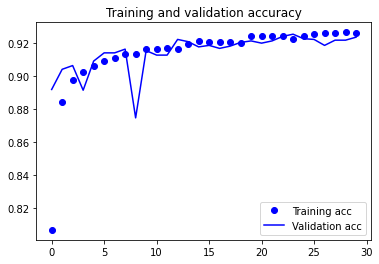

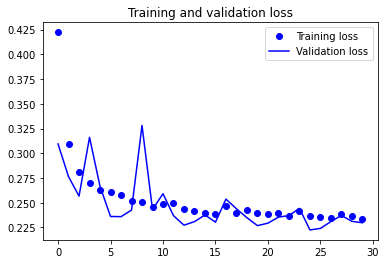

In [54]:
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
model3.evaluate(test_features,test_labels)

173/173 [==============================] - 1s 3ms/step - loss: 0.2212 - acc: 0.9294


[0.22120387852191925, 0.9294267296791077]

In [156]:
from keras import models
from keras import layers
from keras import optimizers
model4 = models.Sequential()
model4.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.7))
model4.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.15))
model4.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.05))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.add(layers.Dense(1024, activation = "relu", input_dim = 2 * 2 * 512))
model4.add(layers.Dropout(0.01))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=['acc'])

history4 = model4.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
4961/4961 [==============================] - 38s 7ms/step - loss: 0.6851 - acc: 0.5180 - val_loss: 0.3863 - val_acc: 0.8512
Epoch 2/30
4961/4961 [==============================] - 37s 7ms/step - loss: 0.3575 - acc: 0.8631 - val_loss: 0.2988 - val_acc: 0.8920
Epoch 3/30
4961/4961 [==============================] - 30s 6ms/step - loss: 0.3113 - acc: 0.8860 - val_loss: 0.2823 - val_acc: 0.8916
Epoch 4/30
4961/4961 [==============================] - 30s 6ms/step - loss: 0.2851 - acc: 0.8999 - val_loss: 0.2783 - val_acc: 0.8988
Epoch 5/30
4961/4961 [==============================] - 31s 6ms/step - loss: 0.2822 - acc: 0.9004 - val_loss: 0.2653 - val_acc: 0.9065
Epoch 6/30
4961/4961 [==============================] - 32s 6ms/step - loss: 0.2673 - acc: 0.9087 - val_loss: 0.2662 - val_acc: 0.9043
Epoch 7/30
4961/4961 [==============================] - 32s 7ms/step - loss: 0.2776 - acc: 0.9027 - val_loss: 0.2527 - val_acc: 0.9047
Epoch 8/30
4961/4961 [==============================] -

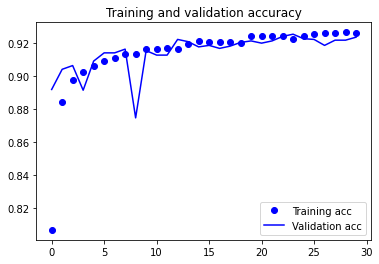

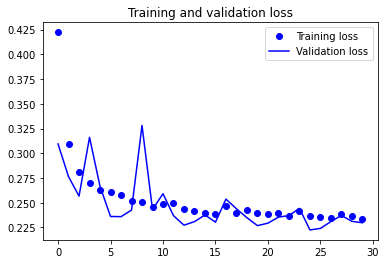

In [157]:
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [158]:
model4.evaluate(test_features,test_labels)

173/173 [==============================] - 1s 5ms/step - loss: 0.2285 - acc: 0.9272


[0.2285424917936325, 0.9272496104240417]

### Adding more layers to the CNN for getting a better accuracy:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
import os
import cv2 as cv
import glob as gb
np.random.seed(2)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Dropout , Flatten , MaxPooling2D , BatchNormalization ,experimental
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [16]:
s=64
X_train=[]
y_train=[]

code={'Uninfected':0,'Parasitized':1}
    
def getcode(n):
    for x,y in code.items() :
        if n==y :
            return x

In [17]:
trainpath = "malaria/cell_images/"

for folder in os.listdir(trainpath):
    files=gb.glob(pathname=str(trainpath+folder+'/*.png'))
    for file in files :
        image=cv.imread(file)
        X_train.append(list(cv.resize(image,(s,s))))
        y_train.append(code[folder])

In [21]:
testpath = "malaria/cell_images/testing"

for folder in os.listdir(trainpath):
    files=gb.glob(pathname=str(testpath+folder+'/*.png'))
    for file in files :
        image=cv.imread(file)
        X_test.append(list(cv.resize(image,(s,s))))
        y_test.append(code[folder])

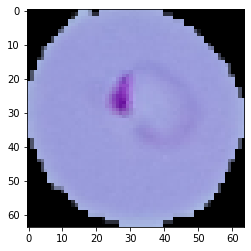

In [22]:
plt.imshow(X_test[0])
plt.show()

In [23]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_train=np.array(X_train)
y_train=np.array(y_train)

In [24]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [25]:
image_gen = ImageDataGenerator(
    
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True

)


image_gen.fit(X_test, augment=True)

In [26]:
model1=Sequential([

    Conv2D(filters=32,kernel_size=(2,2),padding='valid',activation='relu',input_shape=(s,s,3)),
    
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=64,kernel_size=(2,2),padding='valid',activation='relu'),
    
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=128,kernel_size=(2,2),padding='same',activation='relu'),

    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
    
    MaxPooling2D(pool_size=(3,3),strides=(2,2)),

    Flatten(),

    Dense(256,activation='relu'),
    
    Dense(265,activation='relu'),

    Dense(128,activation='relu'),
    
    Dense(64,activation='relu'),

    Dense(1,activation='sigmoid')

    ])



model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

In [27]:
callback = EarlyStopping(restore_best_weights=True, patience=2)

In [28]:
history = model1.fit(X_test,y_test,validation_split=0.1,epochs=100,batch_size=32, callbacks=[callback], verbose=1)
len(history.history['loss'])

Epoch 1/100
776/776 [==============================] - 136s 174ms/step - loss: 0.7461 - accuracy: 0.8021 - val_loss: 0.1368 - val_accuracy: 0.9594
Epoch 2/100
776/776 [==============================] - 142s 183ms/step - loss: 0.1690 - accuracy: 0.9460 - val_loss: 0.1502 - val_accuracy: 0.9572
Epoch 3/100
776/776 [==============================] - 137s 176ms/step - loss: 0.1515 - accuracy: 0.9528 - val_loss: 0.1254 - val_accuracy: 0.9604
Epoch 4/100
776/776 [==============================] - 136s 175ms/step - loss: 0.1317 - accuracy: 0.9568 - val_loss: 0.1246 - val_accuracy: 0.9615
Epoch 5/100
776/776 [==============================] - 137s 177ms/step - loss: 0.1261 - accuracy: 0.9569 - val_loss: 0.1284 - val_accuracy: 0.9608
Epoch 6/100
776/776 [==============================] - 137s 176ms/step - loss: 0.1143 - accuracy: 0.9618 - val_loss: 0.1258 - val_accuracy: 0.9594


6

In [29]:
ModelLoss, ModelAccuracy = model1.evaluate(X_test, y_test)
y_pred=model1.predict(X_test)

862/862 [==============================] - 35s 41ms/step - loss: 0.1152 - accuracy: 0.9612


In [30]:
print("Model Loss is",ModelLoss)
print("Model Accuracy is", ModelAccuracy)

Model Loss is 0.11515133082866669
Model Accuracy is 0.9612453579902649


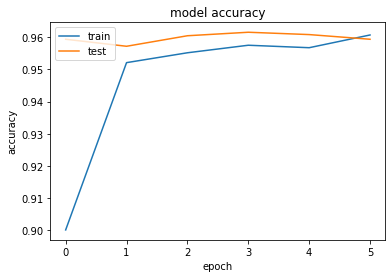

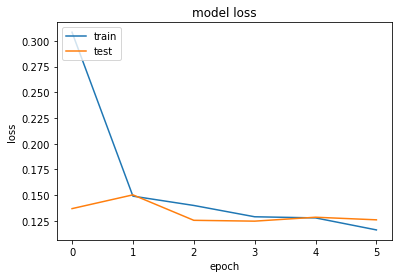

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### The best model accuracy is 96.12453579902649%